
This code containts a simple application of PySINDY. In this code, firstly noisy data will be generated. This data represents the x and y coordinates of a free-falling projectile. After that, the equation of the free-fall motion will be recovered using sparse identification by PySINDy. 



In [18]:
!pip install pysindy # Downloading PySINDy.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [233]:
import numpy as np
import pandas as pd     # Importing the necesarry libraries and packages. 
import pysindy as ps
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline



Firtsly, the functions which will be used during the code are defined.

In [234]:
def projectile2dim(t,state,g):

  # This is the function which will be used in scipy.integrate to generate the training data.
  
  x,vx,y,vy = state

  dx = vx
  dvx = 0
  dy = vy
  dvy = -g

  return [dx,dvx,dy,dvy]

In [21]:
def generateData(init,tStart,tStop,dt,noiseLevel):

  # This function generates noisy data to train the PySINDy model.

  # Input Arguments: 
  # - init(type:list): Initial condition in a list. The format is [x,vx,y,vy] where vx and vy are speeds.
  # - tStart(type:float): The starting time of generation of data.
  # - tStop(type:float): The stopping time of generation of data.
  # - dt(type:float): The time interval between data points.
  # - noiseLevel(type:float): The level (variance) of the noise that will be added to the generated data. 

  # Output Arguments:
  # - x_train(type:numpy array) : The training data array.
  # - t_train(type:numpy array) : The training data time instants in an array.



  integrator_keywords = {}
  integrator_keywords['rtol'] = 1e-12
  integrator_keywords['method'] = 'LSODA'
  integrator_keywords['atol'] = 1e-12
  
  g = 10
  args = [g]

  t_train = np.arange(tStart, tStop, dt) 
  t_train_span = (t_train[0], t_train[-1])

  #  Solution according to the inital values provided by 'x0_train'. 
  x_train = solve_ivp(projectile2dim, t_train_span,                                  
                    init, t_eval=t_train,**integrator_keywords,args=args).y.T
  
  # Creating and adding the specified amount of Additive White Gaussian Noise (AWGN). 

  for i in range(3):
   noiseVector = np.random.normal(0,pow(noiseLevel,2),len(x_train))
   x_train[:,i] = x_train[:,i] + noiseVector
  
  return x_train,t_train
  

In [150]:
def plotTrajectory(Xplot):

    # This function plots the data arrays to visualize the results. This function works for 2 cases:
    # plotting a single data array and comparing 2 data arrays. In the first case only a numpy array 
    # should be passed to the function. In the second case, a list of arrays should be paseed. The
    # list can contain only 2 different data arrays.

    # Input Arguments: 
    # - Xplot(type:list or numpy array): The array or list of arrays which will be visualized.
     

    plt.figure(figsize=(9,7), dpi=100)

    if type(Xplot) != list:
    
   
     x = Xplot[:,0]
     y = Xplot[:,2]
   
     plt.plot(x, y)
     plt.ylabel('Y-Coordinate')
     plt.xlabel('X-Coordinate') 
     plt.title('Plot of the Trajectory')
     plt.grid(True)

    else:

    
     x1 = Xplot[0][:,0]
     y1 = Xplot[0][:,2]
     x2 = Xplot[1][:,0]
     y2 = Xplot[1][:,2]
    
     plt.plot(x1, y1, color='r', label='Prediction')
     plt.plot(x2, y2, color='b', label='Training')
     plt.ylabel('Y-Coordinate')
     plt.xlabel('X-Coordinate') 
     plt.title('Plot of the Trajectory')
     plt.grid(True)
     plt.legend()


  



Now, comes the main code. Firstly, we define the necesarry parameters for the simulation and generate the training data for the PySINDy.

In [238]:
initial_condition = [1,3,2,-3] # Defining the initial condition.

tStart = 0  # The time of the start of training data.
tStop = 4   # The time of the stop of the training data(the traning data stops at tStop-dt).
dt =  0.1   # Time step.
noiseLevel = 0.2  # Variance of the AWGN added. Note that the noise is added to all 4 dynamical variables of the system independently. 


Now, generating the training data.

In [239]:
Xtrain,ttrain = generateData(initial_condition,tStart,tStop,dt,noiseLevel) # Generation of the training data with the specified params.


Plotted the generated data.







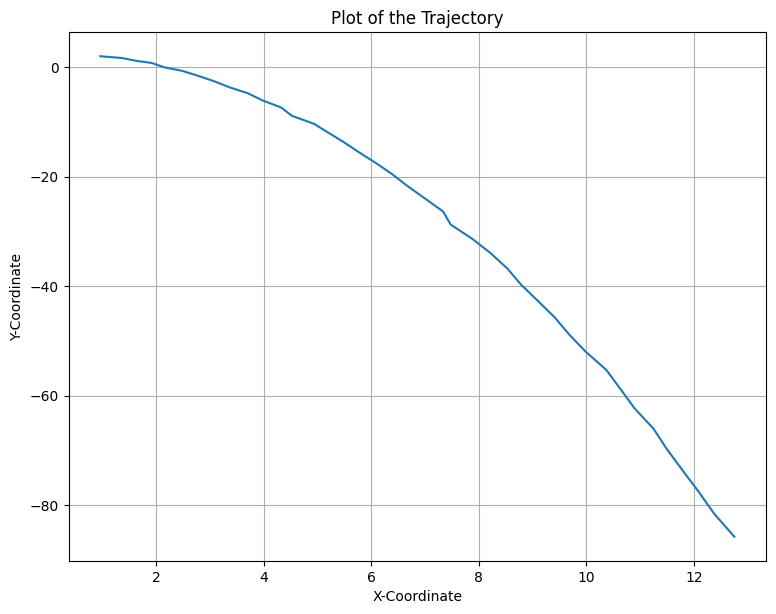

In [240]:
plotTrajectory(Xtrain)      # The trajectory.

Now, comes the PySINDy part. We first, choose the model parameters and methods for our PySINDy model.

In [241]:
# Choosing the correct optimizer and correct parameters. Note that this parameters
# are critical in obtaining the correct equations.So they must be tuned (manually for now).
from pysindy.optimizers import STLSQ
opt = STLSQ(threshold=0.5, alpha=1,max_iter=100, verbose=True)


In [242]:
# Choosing the feature libraries.

from pysindy.feature_library import IdentityLibrary
from pysindy.feature_library import PolynomialLibrary
identityLib = ps.IdentityLibrary()
polyLib = ps.PolynomialLibrary(degree=0)
feature_lib = polyLib + identityLib


In [243]:
# Choosing the differentiation method. 
from pysindy.differentiation import SmoothedFiniteDifference
diffMethod = SmoothedFiniteDifference()


Now, we initialize and fit our model.

In [244]:
model = ps.SINDy(
        optimizer=opt,
        feature_library=feature_lib,
        discrete_time = False,
        feature_names = ['x','vx','y','vy']

    )

In [245]:
 model.fit(
        Xtrain,
        t=ttrain,
        quiet=True,
        

    )

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.8525e+02 ... 1.1068e+01 ...          4 ... 1.9632e+02
         1 ... 2.1668e+01 ... 1.1986e+01 ...          4 ... 3.3655e+01


SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.base.ConcatLibrary object at 0x7fc0ce161290>,
      feature_names=['x', 'vx', 'y', 'vy'],
      optimizer=STLSQ(alpha=1, max_iter=100, threshold=0.5, verbose=True))

Printing model equations.

In [246]:
model.print()

(x)' = 1.024 vx
(vx)' = 0.000
(y)' = 1.000 vy
(vy)' = -10.000 1


In [247]:
xPred = model.simulate(np.array(initial_condition),ttrain) # Predicting the training data.

In [248]:
xPlot = [xPred,Xtrain] 

Lastly, the prediction and the training data are being compared.
The red trajectory and the blue trajectory should be as close as possible.

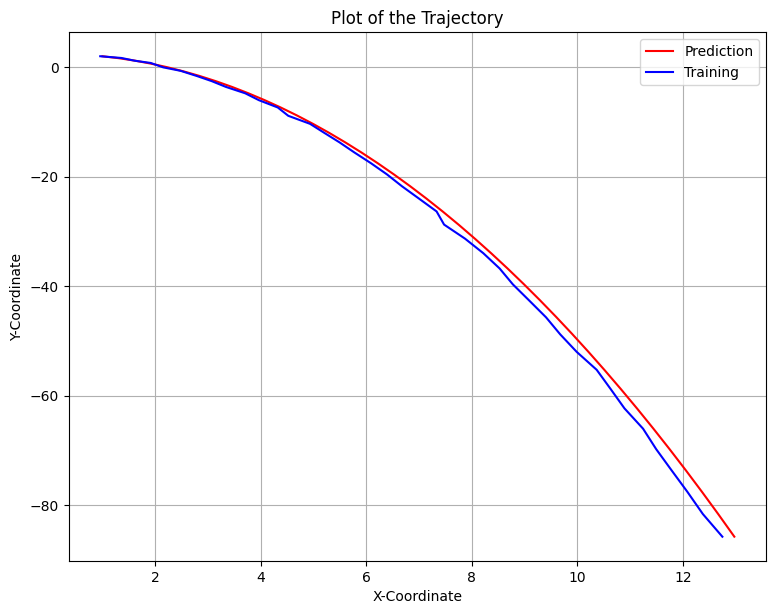

In [249]:
plotTrajectory(xPlot)  